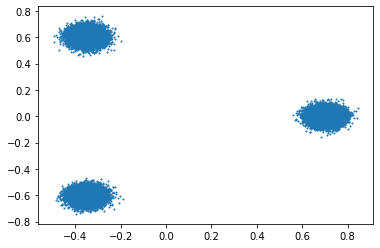

In [296]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import random
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.05
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32) * 0.7
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        # return self.data[idx], self.label[idx]
        return self.data[idx]


data_size = 60000
dataset = CustomDataSet(n_group=3, n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [297]:
device = 'cpu'

In [298]:
class Discriminator(torch.nn.Module):

    def __init__(self, n_in, n_out):
        super(Discriminator, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_in, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=16, out_features=n_out, bias=True),
            torch.nn.Softmax(dim=1)
        ).to(device)

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        return self.net(x)


class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out):
        super(Generator, self).__init__()
        self.z_dim = n_in

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.z_dim, 32), 
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, n_out)
        ).to(device)
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        return self.net(x)



def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [318]:
mb_size = 64
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=mb_size,
                                     shuffle=True,
                                     drop_last=True)


X_DIM = 2
Z_DIM = 3
Y_DIM = 3
discriminator = Discriminator(X_DIM, Y_DIM)
generator = Generator(Z_DIM, X_DIM)
d_solver = optim.Adam(discriminator.parameters(), lr=1e-4)
g_solver = optim.Adam(generator.parameters(), lr=1e-4)

In [364]:
num_epochs = 1

for epoch in range(num_epochs):
    METRIC1_AVG = 0.0
    METRIC2_AVG = 0.0
    for _, X in enumerate(loader):
        X = X.to(device)

        d_solver.zero_grad()
        Yx = discriminator(X)
        H_Y_GIVEN_X = torch.mean(torch.sum(-Yx * torch.log(Yx +1e-6), dim=1))
        marginal_Yx = torch.mean(Yx, dim=0)
        H_Yx = torch.sum(-marginal_Yx * torch.log(marginal_Yx+1e-6))
        Yg = discriminator(generator(torch.randn(mb_size, Z_DIM).to(device)))
        H_Y_GIVEN_Gz = torch.mean(torch.sum(-Yg * torch.log(Yg+1e-6), dim=1))
        D_loss = H_Y_GIVEN_X - H_Y_GIVEN_Gz - H_Yx
        D_loss.backward()
        d_solver.step()

        METRIC1_AVG += H_Y_GIVEN_X.item()
        METRIC2_AVG += H_Y_GIVEN_Gz.item()

        g_solver.zero_grad()
        Yg = discriminator(generator(torch.randn(mb_size, Z_DIM).to(device)))
        H_Y_GIVEN_Gz = torch.mean(torch.sum(-Yg * torch.log(Yg+1e-6), dim=1))
        marginal_Yg = torch.mean(Yg, dim=0)
        H_Yg = torch.sum(-marginal_Yg * torch.log(marginal_Yg+1e-6))
        G_loss = H_Y_GIVEN_Gz - H_Yg
        G_loss.backward()
        g_solver.step()


    METRIC1_AVG /= len(loader)
    METRIC2_AVG /= len(loader)

    print(METRIC1_AVG, METRIC2_AVG)


0.3010872559206463 0.30983911678910636


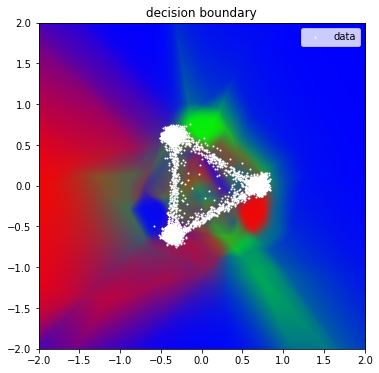

In [373]:
resol = 200
left_point = -2.0
right_point = 2.0
offset = (right_point - (left_point))/resol 

p = np.ones((resol, resol, 3), np.float64)


x_region = torch.zeros((resol, resol, 2), dtype=torch.float)
for a_step in range(resol):
    for b_step in range(resol):
        x_region.data[a_step][b_step][0] = left_point + offset * (a_step)
        x_region.data[a_step][b_step][1] = left_point + offset * (b_step)

y = discriminator(x_region.reshape(-1, 2)).reshape(resol, resol, 3)
for a_step in range(resol):
    for b_step in range(resol):
        p[b_step][a_step][0] = y[resol - 1 - b_step][a_step][0]
        p[b_step][a_step][1] = y[resol - 1 - b_step][a_step][1]
        p[b_step][a_step][2] = y[resol - 1 - b_step][a_step][2]

plt.figure(figsize=(6, 6))
plt.title('decision boundary')
plt.imshow(p, interpolation='spline36', extent=[left_point, right_point, left_point, right_point])  #first dim = y axis,  second dim = x axis
sample = generator(torch.randn(80000, Z_DIM).to(device)).detach().numpy()
plt.scatter(sample[:, 0], sample[:, 1], s=1, c='#FFFFFF',label='data')
plt.legend()
plt.show()